In [82]:
import torch

from dataset.dataset import MultimodalPretrainedEmbeddingsDataset
from models.adaptor import Adaptor
from models.configurations import TEXT_PRETRAINED, VISION_PRETRAINED
from utils.dataset_utils import get_dataloader
from utils.model_utils import get_newest_ckpt
import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

import numpy as np


def apply_pca_then_tsne(data, n_pca_components=50, perplexity=20, n_iter=1000, random_state=1024):
    # Apply PCA first
    pca = PCA(n_components=n_pca_components, random_state=random_state)
    pca_result = pca.fit_transform(data)
    
    # Then apply t-SNE
    tsne = TSNE(n_components=2, random_state=random_state, verbose=1, perplexity=perplexity, n_iter=n_iter)
    tsne_result = tsne.fit_transform(pca_result)
    
    return tsne_result



def apply_pca_then_umap(data, n_pca_components=50, n_neighbors=20, min_dist=0.1, n_components=2, random_state=1024):
    # Apply PCA first
    pca = PCA(n_components=n_pca_components, random_state=random_state)
    pca_result = pca.fit_transform(data)
    
    # Then apply UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state)
    umap_result = reducer.fit_transform(pca_result)
    
    return umap_result

In [62]:
vision_model = "dinov2-b"
text_model = "bert"
num_of_samples = 1000
batch_size = 16
num_workers = 8

projection_dim = 768


vision_model_config = VISION_PRETRAINED[vision_model]
vision_pretrained = vision_model_config["pretrained_weight"]
vision_model_type = vision_model_config["vision_model_type"]
vision_output_dim = vision_model_config["vision_output_dim"]
text_pretrained = TEXT_PRETRAINED[text_model]

val_dataset = MultimodalPretrainedEmbeddingsDataset(
    text_model,
    vision_model,
    split="valid",
    num_of_samples=num_of_samples,
)
val_dataloader = get_dataloader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    collate_fn=None,
)

In [21]:
adaptor_ckpt = get_newest_ckpt(
    vision_model, text_model, postfix="v3", 
    project_name="adaptor_pretrain_v3", 
)

adaptor = Adaptor.load_from_checkpoint(adaptor_ckpt)
adaptor.eval()

Adaptor(
  (projection): Project(
    (visual_projection): Linear(in_features=768, out_features=768, bias=False)
    (text_projection): Linear(in_features=768, out_features=768, bias=False)
  )
  (adaptor_module): AdaptorModule(
    (encoder): ModuleList(
      (0): TransformerEncoderLayerWithCrossAttention(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayerWithCrossAttention(
        (attn): MultiheadAttention(
         

In [34]:
text_embeds_pre_adaptor = []
text_embeds_post_adaptor = []
vision_embeds_pre_adaptor = []
vision_embeds_post_adaptor = []

for batch in tqdm.tqdm(val_dataloader):
    text, vision = batch["text_embeds_raw"], batch["image_embeds_raw"]
    
    text_embeds_pre_adaptor.append(text)
    vision_embeds_pre_adaptor.append(vision)
    
    adaptor_outputs = adaptor(image_embeds_raw=vision, text_embeds_raw=text)
    
    text_embeds_post_adaptor.append(adaptor_outputs["text_embeds"].detach().cpu())
    vision_embeds_post_adaptor.append(adaptor_outputs["image_embeds"].detach().cpu())

100%|██████████| 63/63 [01:17<00:00,  1.23s/it]


In [35]:
text_embeds_pre_adaptor = torch.cat(text_embeds_pre_adaptor, dim=0)
vision_embeds_pre_adaptor = torch.cat(vision_embeds_pre_adaptor, dim=0)
text_embeds_post_adaptor = torch.cat(text_embeds_post_adaptor, dim=0)
vision_embeds_post_adaptor = torch.cat(vision_embeds_post_adaptor, dim=0)

In [89]:
# tsne_before = apply_pca_then_tsne(
#     torch.cat([text_embeds_pre_adaptor, vision_embeds_pre_adaptor], dim=0).numpy(),
# )
# tsne_after = apply_pca_then_tsne(
#     torch.cat([text_embeds_post_adaptor, vision_embeds_post_adaptor], dim=0).numpy(),
# )

reduction_before = apply_pca_then_umap(
    torch.cat([text_embeds_pre_adaptor, vision_embeds_pre_adaptor], dim=0).numpy(), random_state=809,
)
reduction_after = apply_pca_then_umap(
    torch.cat([text_embeds_post_adaptor, vision_embeds_post_adaptor], dim=0).numpy(), random_state=809,
)

In [90]:
reduction_df = pd.DataFrame({
    'x_raw': reduction_before[:, 0],
    'y_raw': reduction_before[:, 1],
    'x': reduction_after[:, 0],
    'y': reduction_after[:, 1],
    'labels': ["text"] * num_of_samples + ["vision"] * num_of_samples, 
})

print(reduction_df.head())

       x_raw     y_raw         x         y labels
0  17.580637  4.843096 -8.917832  4.668670   text
1  15.497424  5.250254 -8.554504  4.812810   text
2  13.340832  3.600706 -8.707184  6.383450   text
3  11.746368  5.055070 -5.275908  5.365946   text
4  13.202786  3.979693 -8.043328  6.065220   text


In [91]:
n_subset = 1000
subset = pd.concat([reduction_df[:n_subset], reduction_df[num_of_samples:num_of_samples + n_subset]], axis=0)

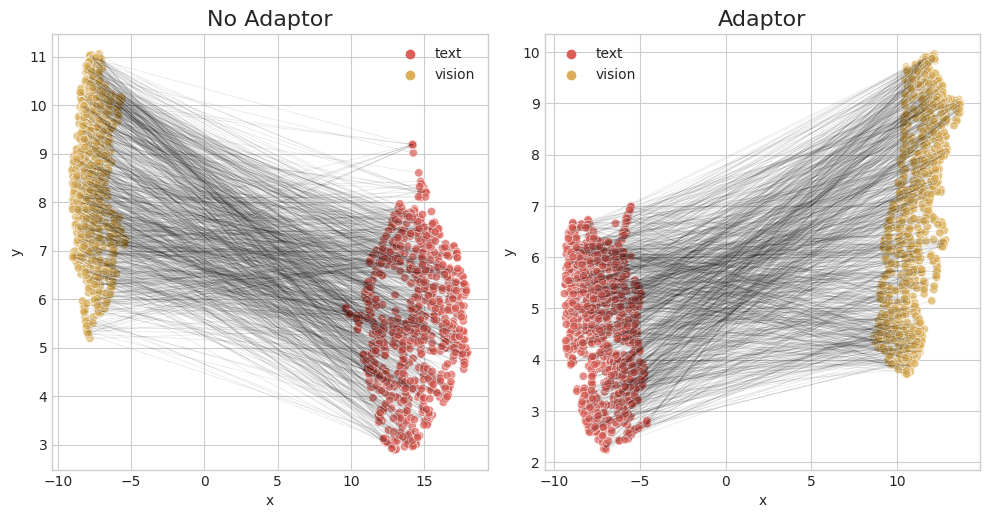

In [93]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("No Adaptor", fontsize=16)
# ax[0].set_xticks([])
# ax[0].set_yticks([])

ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Adaptor", fontsize=16)
# ax[1].set_xticks([])
# ax[1].set_yticks([])


for i in range(n_subset):
    x0, y0 = subset.iloc[i][:2]
    x1, y1 = subset.iloc[i + n_subset][:2]
    ax[0].plot([x0, x1], [y0, y1],
               color="black", alpha=0.1, linewidth=0.5) 
    
sns.scatterplot(
    x="x_raw", y="y_raw",
    hue="labels",
    palette=sns.color_palette("hls", 10),
    data=subset,
    legend="full",
    alpha=0.7, 
    ax=ax[0]
)
    
for i in range(n_subset):
    x0, y0 = subset.iloc[i][2:4]
    x1, y1 = subset.iloc[i + n_subset][2:4]
    ax[1].plot([x0, x1], [y0, y1],
               color="black", alpha=0.1, linewidth=0.5) 
    
sns.scatterplot(
    x="x", y="y",
    hue="labels",
    palette=sns.color_palette("hls", 10),
    data=subset,
    legend="full",
    alpha=0.7, 
    ax=ax[1]
)


ax[0].legend().set_label("")
ax[1].legend().set_label("")

ax[0].set_aspect(1.0/ax[0].get_data_ratio(), 'box')
ax[1].set_aspect(1.0/ax[1].get_data_ratio(), 'box')

plt.tight_layout()
plt.savefig("figs/pretrain_embeddings_umap.png", dpi=300, facecolor='white', bbox_inches='tight')